In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
train_path=r"C:\Users\Pradeesh\Learning Zone\DL\Emotion detection\train"
test_path=r"C:\Users\Pradeesh\Learning Zone\DL\Emotion detection\test"

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
train_data_gen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=10,
    height_shift_range=10,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)
test_data_gen=ImageDataGenerator(rescale=1./255)


In [5]:
train_data=train_data_gen .flow_from_directory(
    train_path,
    target_size=(48,48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    subset='training'
)
val_data=train_data_gen .flow_from_directory(
    train_path,
    target_size=(48,48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)
test_data=test_data_gen.flow_from_directory(
    test_path,
    target_size=(48,48),
    batch_size=32,
    color_mode='grayscale',
    shuffle=False
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
train_data.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [7]:
emotions=['angry','disgust','fear','happy','neutral','sad','surprise']

In [8]:
classes=np.unique(train_data.classes,return_counts=True)
print("Classs",classes[0])
print("Count",classes[1])

Classs [0 1 2 3 4 5 6]
Count [3196  349 3278 5772 3972 3864 2537]


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

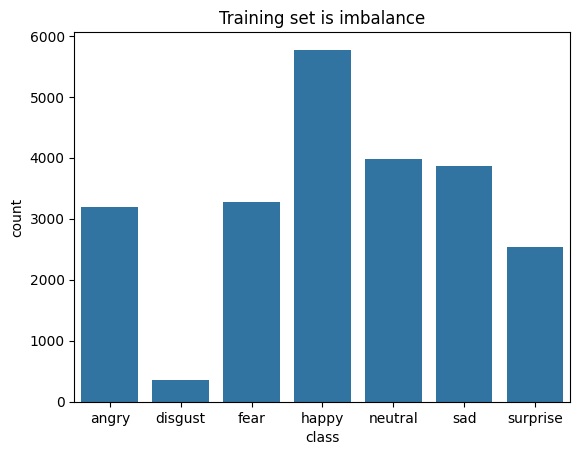

In [10]:
sns.barplot(x=emotions,y=classes[1])
plt.title("Training set is imbalance")
plt.xlabel('class')
plt.ylabel('count') 
plt.show()

In [11]:
from sklearn.utils.class_weight import compute_class_weight

In [12]:
class_weights=compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights

array([1.02664044, 9.40155546, 1.00095877, 0.56845857, 0.82606819,
       0.84915705, 1.29331607])

In [13]:
class_weights=dict(enumerate(class_weights))

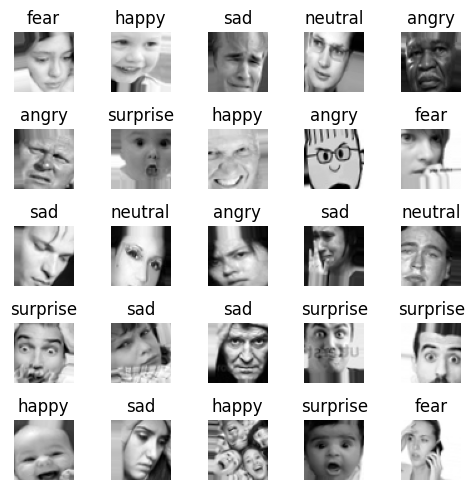

In [14]:
fig,ax=plt.subplots(5,5,figsize=(5,5))
ax=ax.flatten()
for i in range(25):
    num=np.random.randint(train_data.n)
    image_batch,batch_labels=train_data[num//32]
    image_id=num%32
    image=image_batch[image_id]
    label=batch_labels[image_id].argmax()

    ax[i].imshow(image,cmap='gray')
    ax[i].set_title(emotions[label])
    ax[i].axis("off")
plt.tight_layout()
plt.show()

In [15]:
def identity_block(x,filters):
    x_skip=x
    x=tf.keras.layers.Conv2D(kernel_size=(3,3),filters=filters,padding='same',strides=1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.ReLU()(x)
    
    x=tf.keras.layers.Conv2D(kernel_size=(3,3),filters=filters,padding='same',strides=1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    
    x=tf.keras.layers.Add()([x,x_skip])
    x=tf.keras.layers.ReLU()(x)
    return x



In [16]:
def convolutional_block(x,filters):
    x_skip=x
    x=tf.keras.layers.Conv2D(kernel_size=(3,3),filters=filters,padding='same',strides=2)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.ReLU()(x)

    x=tf.keras.layers.Conv2D(kernel_size=(3,3),filters=filters,padding='same',strides=1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    
    x_skip=tf.keras.layers.Conv2D(kernel_size=(1,1),filters=filters,strides=2,padding='same')(x_skip)
    x=tf.keras.layers.Add()([x,x_skip])
    x=tf.keras.layers.ReLU()(x)
    
    return x

In [17]:
def resnet34(shape=(48,48,1),classes=7):
    x_input=tf.keras.layers.Input(shape)

    x=tf.keras.layers.ZeroPadding2D(padding=(1,1))(x_input)
    x=tf.keras.layers.Conv2D(kernel_size=(3,3),filters=64,padding='same',strides=1)(x)
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.ReLU()(x)

    x=convolutional_block(x,64)
    x=identity_block(x,64)
    x=identity_block(x,64)

    x=convolutional_block(x,128)
    x=identity_block(x,128)
    x=identity_block(x,128)
    x=identity_block(x,128)

    x=convolutional_block(x,256)
    x=identity_block(x,256)
    x=identity_block(x,256)
    x=identity_block(x,256)
    x=identity_block(x,256)
    x=identity_block(x,256)

    x=convolutional_block(x,512)
    x=identity_block(x,512)
    x=identity_block(x,512)

    x=tf.keras.layers.GlobalAveragePooling2D()(x)
    x=tf.keras.layers.Dense(256,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)
    x=tf.keras.layers.Dense(classes,activation='softmax')(x)

    model=tf.keras.models.Model(inputs=x_input,outputs=x,name='Resnet34')
    return model



In [18]:
model=resnet34()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'],loss='categorical_crossentropy')

In [19]:
model.summary()

Model: "Resnet34"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 50, 50, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   640         ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                

In [20]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=10,          
    restore_best_weights=True,  
    verbose=1
)
model_checkpoint =tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)


history=model.fit(train_data,validation_data=val_data,verbose=1,epochs=300,callbacks=[early_stop,model_checkpoint],class_weight=class_weights)

Epoch 1/300
718/718 [==============================] - 108s 120ms/step - loss: 2.0051 - accuracy: 0.1603 - val_loss: 1.9506 - val_accuracy: 0.1604
Epoch 2/300
718/718 [==============================] - 83s 115ms/step - loss: 1.9259 - accuracy: 0.1805 - val_loss: 1.9281 - val_accuracy: 0.1876
Epoch 3/300
718/718 [==============================] - 471s 656ms/step - loss: 1.8938 - accuracy: 0.1935 - val_loss: 1.9244 - val_accuracy: 0.1853
Epoch 4/300
718/718 [==============================] - 161s 223ms/step - loss: 1.8787 - accuracy: 0.2008 - val_loss: 1.8801 - val_accuracy: 0.2473
Epoch 5/300
718/718 [==============================] - 89s 123ms/step - loss: 1.8548 - accuracy: 0.2020 - val_loss: 1.8616 - val_accuracy: 0.2376
Epoch 6/300
718/718 [==============================] - 68s 94ms/step - loss: 1.8352 - accuracy: 0.2140 - val_loss: 1.9551 - val_accuracy: 0.1346
Epoch 7/300
718/718 [==============================] - 69s 96ms/step - loss: 1.8173 - accuracy: 0.2094 - val_loss: 1.8223 

In [21]:
score= model.evaluate(test_data)
print("Loss :",score[0])
print("Accuracy :",score[1])


225/225 [==============================] - 89s 399ms/step - loss: 1.0250 - accuracy: 0.6308
Loss : 1.025046706199646
Accuracy : 0.6308164000511169


In [22]:
prediction=model.predict(test_data)
prediction=np.argmax(prediction)

225/225 [==============================] - 5s 20ms/step


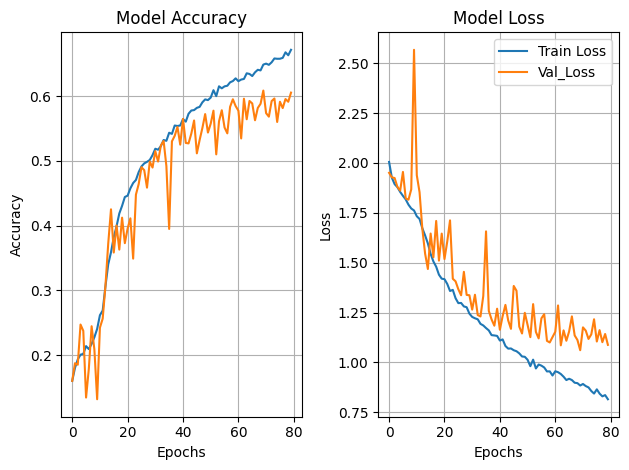

In [24]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Train Loss',)
plt.plot(history.history['val_loss'],label='Val_Loss',)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()


plt.tight_layout()
plt.legend()
plt.show()

In [35]:
prediction=model.predict(test_data)
prediction=np.argmax(prediction,axis=1)

225/225 [==============================] - 6s 26ms/step


In [33]:
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(test_data.classes,prediction))



[[ 526   44   92   21  138   92   45]
 [  27   71    0    1    5    3    4]
 [ 111   15  438   20  157  157  126]
 [  62   11   42 1435  120   42   62]
 [  49    8   54   72  873  116   61]
 [ 111   24  131   53  295  586   47]
 [  26    8   52   24   21   12  688]]


In [34]:
print(classification_report(test_data.classes,prediction))

              precision    recall  f1-score   support

           0       0.58      0.55      0.56       958
           1       0.39      0.64      0.49       111
           2       0.54      0.43      0.48      1024
           3       0.88      0.81      0.84      1774
           4       0.54      0.71      0.61      1233
           5       0.58      0.47      0.52      1247
           6       0.67      0.83      0.74       831

    accuracy                           0.64      7178
   macro avg       0.60      0.63      0.61      7178
weighted avg       0.65      0.64      0.64      7178



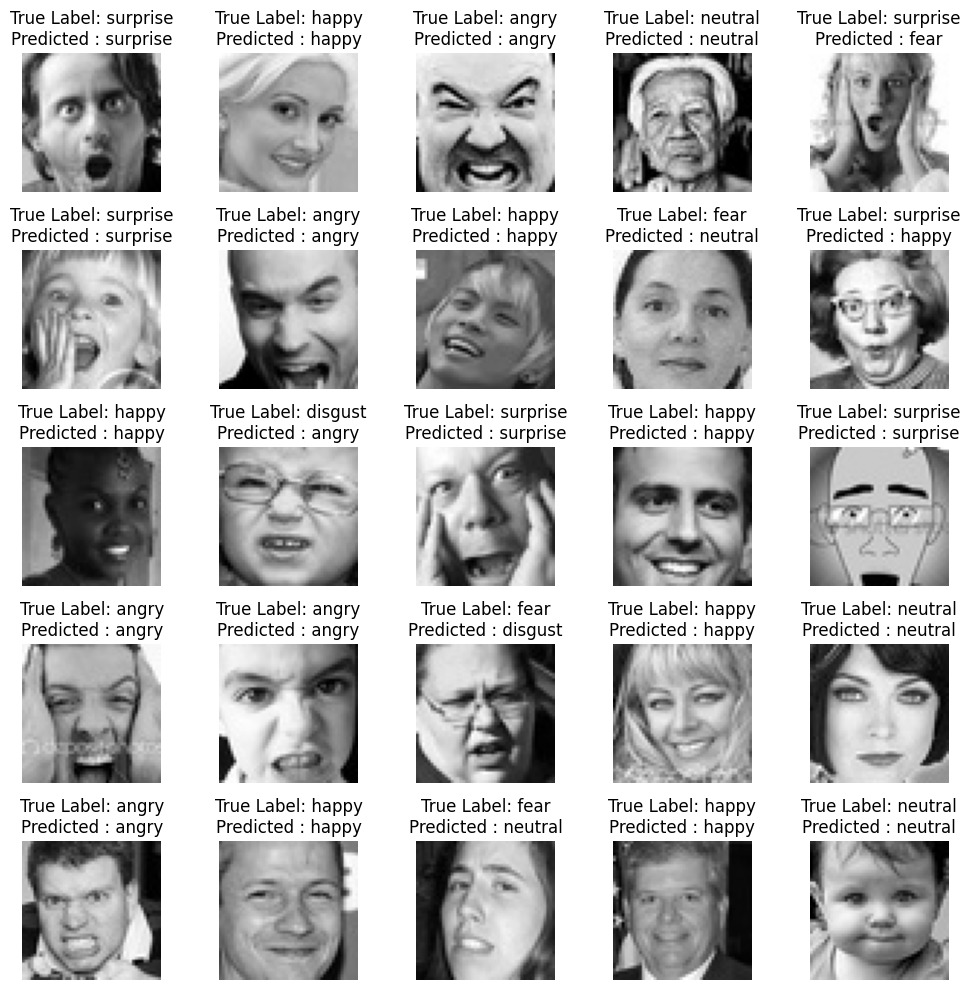

In [45]:
fig,ax=plt.subplots(5,5,figsize=(10,10))
ax=ax.flatten()
for i in range(25):
    num=np.random.randint(test_data.n)
    image_batch,batch_labels=test_data[num//32]
    image_id=num%32
    image=image_batch[image_id]
    label=batch_labels[image_id].argmax()

    ax[i].imshow(image,cmap='gray')
    ax[i].set_title(f'True Label: {emotions[label]}\nPredicted : {emotions[prediction[num]]}')
    ax[i].axis("off")
plt.tight_layout()
plt.show()